Ref: Preserving Color in Neural Artistic Style Transfer
https://arxiv.org/pdf/1606.05897.pdf 

The Neural Style Transfer Algorithm transforms an image to have the style of another given image. The NST algorithm considers two images, a content image and a style image and outputs a combined image depicting the objects of the content image in the style of the other image.

A potential shortcoming of the method is that the algorithm transfer the colors of the original painting which can alter the appearance in undesirable ways.


An approach by using style transfer only in the luminance channel (since visual perception is far more sensitive to changes in luminance than in color) is presented. 

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg19

In [2]:
import cv2

In [3]:
from matplotlib import pyplot as plt

In [4]:
from IPython.display import Image, display

In [52]:
base_reference_img = tf.keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_img = tf.keras.utils.get_file("stary_night.jpg", "https://i.imgur.com/9ooB60I.jpg")
source = cv2.imread(base_reference_img)
target = cv2.imread(style_reference_img)

In [37]:
style_reference_img = cv2.imread(style_reference_img)

In [10]:
source = cv2.imread('/content/paris.jpg')

In [11]:
target = cv2.imread('/content/stary_night.jpg')

In [12]:
source = cv2.imread('/content/source.png')

In [13]:
target = cv2.imread('/content/target.png')

In [10]:
result_prefix = "paris_generated"

In [11]:
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

In [12]:
width, height  = keras.preprocessing.image.load_img(base_reference_img).size

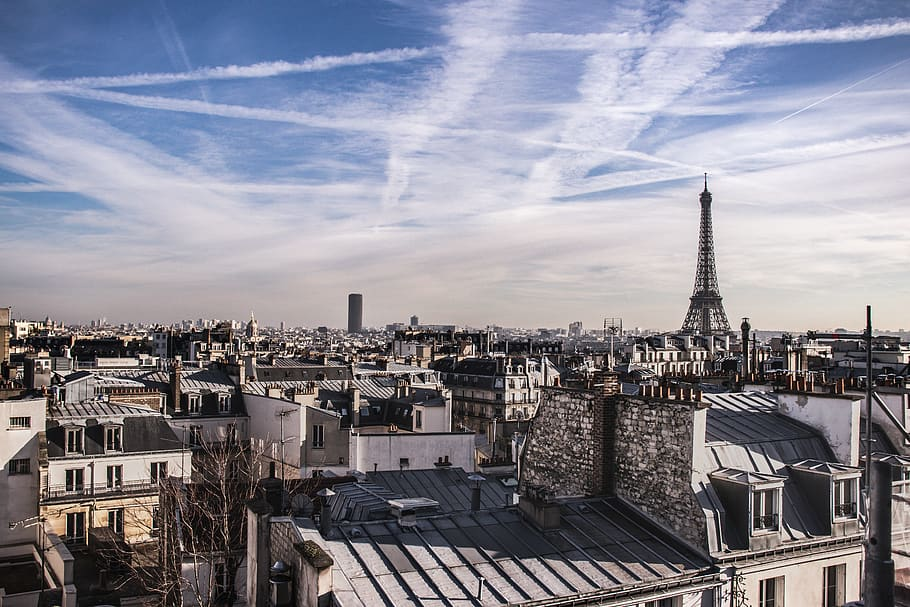

In [13]:
display(Image(base_reference_img))

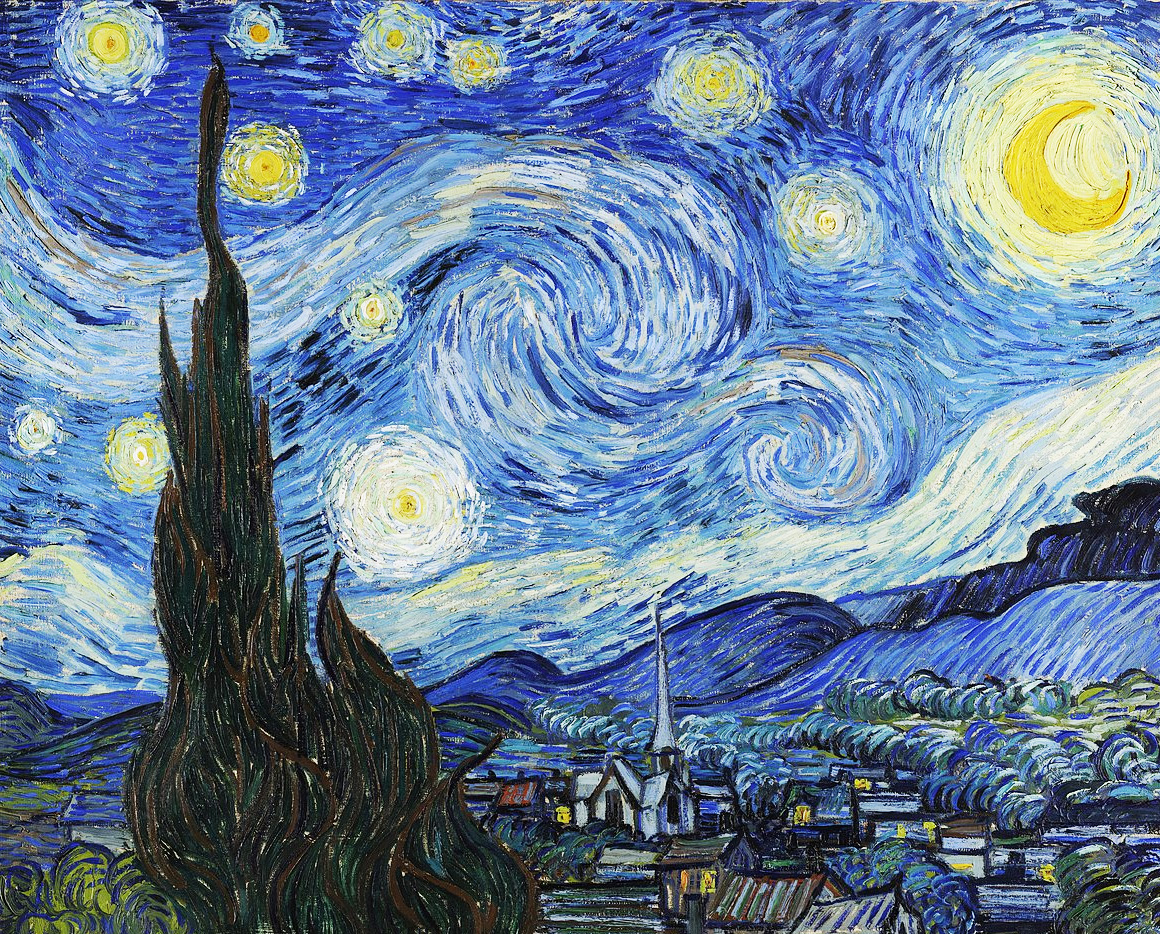

In [14]:
display(Image(style_reference_img))

In [15]:
Image?

In [16]:
def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size = (img_nrows, img_ncols))
    
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img = vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

In [17]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    x[:, :, 0] += 103.939
    x[:,:, 1] += 116.779
    x[:,:,2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype("uint8")
    return x

In [18]:
def gram_matrix(x):
    x = tf.transpose(x, (2,0,1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

In [19]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows*img_ncols
    return tf.reduce_sum(tf.square(S-C))/(4.0*(channels**2)*(size**2))

In [20]:
def content_loss(base, combination):
    return tf.reduce_sum(tf.square(combination - base))

In [21]:
def total_variation_loss(x):
    a = tf.square(x[:, :img_nrows-1, :img_ncols-1, :] - x[:, 1:, :img_ncols-1, :])
    b = tf.square(x[:,:img_nrows-1, :img_ncols-1, :] - x[:, :img_nrows-1, 1:, :])
    return tf.reduce_sum(tf.pow(a+b, 1.25))

In [22]:
model = vgg19.VGG19(weights = "imagenet", include_top = False)

outputs_dict =  dict([(layer.name, layer.output) for layer in model.layers ])

In [23]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)


In [24]:
style_layer_names = [ "block1_conv1",
                     "block2_conv1",
                     "block3_conv1",
                     "block4_conv1",
                     "block5_conv1"
                    ]

In [25]:
content_layer_name = "block5_conv2"

In [55]:
def compute_loss(combination_image, base_image, style_reference_image):
    #Tensors in list passed to 'values' of 'ConcatV2' Op have types [float32, string, float32] that don't all match.
    #style_reference_image = tf.cast(style_reference_image, dtype = tf.float32)
    #base_image = tf.cast(base_image, dtype = tf.float32)
    #combination_image = tf.cast(combination_image, dtype = tf.float32)

    
    input_tensor = tf.concat( [base_image, style_reference_image, combination_image], axis = 0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape = ())
    
    #Add content loss
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0,:,:,:]
    combination_features = layer_features[2,:,:,:]
    loss = loss + content_weight*content_loss(base_image_features, combination_features)
    
    #Add style loss
    
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :,:,:]
        combination_features = layer_features[2,:,:,:]
        sl = style_loss(style_reference_features, combination_features)
        loss+=(style_weight/len(style_layer_names))*sl
        
    #add variational loss
    
    loss += total_variation_weight*total_variation_loss(combination_image)
    return loss

In [45]:
@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads




In [46]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay( initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96

    )
)

In [47]:
width, height  = keras.preprocessing.image.load_img(base_reference_img).size
img_nrows = 400
img_ncols = int(width * img_nrows/height)

In [54]:
base_image = preprocess_image(base_reference_img)
style_reference_image = preprocess_image(style_reference_img)
combination_image = tf.Variable(preprocess_image(base_reference_img))


In [50]:
    style_reference_image = tf.cast(style_reference_image, dtype = tf.float32)
    base_image = tf.cast(base_image, dtype = tf.float32)
    combination_image = tf.cast(combination_image, dtype = tf.float32)


In [56]:
iterations = 4000

img_overall = []

for i in range(1, iterations+1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    
    optimizer.apply_gradients([ (grads, combination_image)   ]   )
    if i %100 == 0:
        print("Iteration % d: loss %.2f" % (i, loss))
        img  = deprocess_image(combination_image.numpy())
        img_overall.append(img)
        #fname = "Gen_images"+result_prefix + "_at_iteration_%d.png"%i
        #keras.preprocessing.image.save_img(fname, img)

Iteration  100: loss 11018.06
Iteration  200: loss 8513.92
Iteration  300: loss 7571.40
Iteration  400: loss 7063.82
Iteration  500: loss 6735.97
Iteration  600: loss 6501.41
Iteration  700: loss 6322.91
Iteration  800: loss 6181.20
Iteration  900: loss 6065.27
Iteration  1000: loss 5967.79
Iteration  1100: loss 5884.61
Iteration  1200: loss 5812.92
Iteration  1300: loss 5750.53
Iteration  1400: loss 5695.76
Iteration  1500: loss 5647.30
Iteration  1600: loss 5604.17
Iteration  1700: loss 5565.43
Iteration  1800: loss 5530.59
Iteration  1900: loss 5499.04
Iteration  2000: loss 5470.32
Iteration  2100: loss 5444.20
Iteration  2200: loss 5420.26
Iteration  2300: loss 5398.30
Iteration  2400: loss 5378.07
Iteration  2500: loss 5359.42
Iteration  2600: loss 5342.19
Iteration  2700: loss 5326.26
Iteration  2800: loss 5311.50
Iteration  2900: loss 5297.78
Iteration  3000: loss 5284.99
Iteration  3100: loss 5273.08
Iteration  3200: loss 5261.95
Iteration  3300: loss 5251.54
Iteration  3400: l

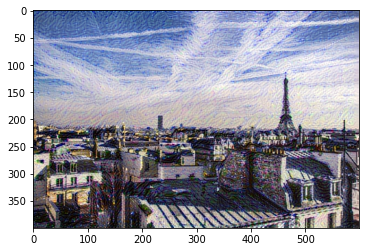

In [59]:
plt.imshow(img_overall[0])

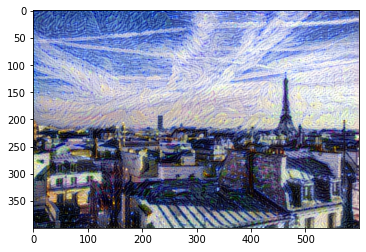

In [60]:
plt.imshow(img_overall[10])

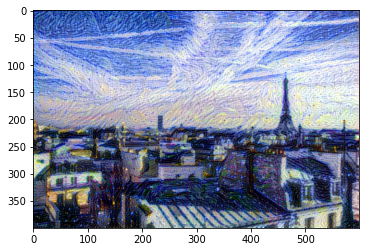

In [61]:
plt.imshow(img_overall[20])

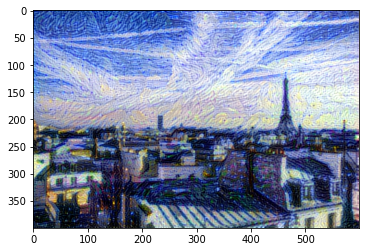

In [62]:
plt.imshow(img_overall[30])

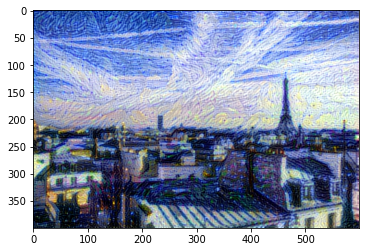

In [64]:
plt.imshow(img_overall[39])

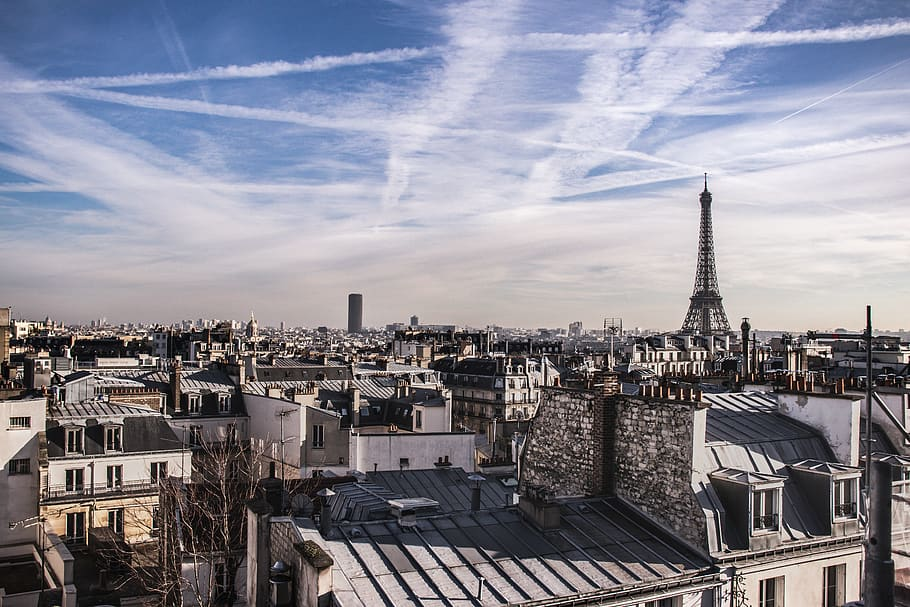

In [65]:
display(Image(base_reference_img))

In [66]:
base_reference_img = tf.keras.utils.get_file("paris.jpg", "https://i.imgur.com/F28w3Ac.jpg")
style_reference_img = tf.keras.utils.get_file("stary_night.jpg", "https://i.imgur.com/9ooB60I.jpg")
source = cv2.imread(base_reference_img)
target = cv2.imread(style_reference_img)

In [67]:
#variation - color preservation
#this primitive method is really bad!!

source_lab = cv2.cvtColor(source, cv2.COLOR_BGR2LAB).astype("float32")
target_lab = cv2.cvtColor(target, cv2.COLOR_BGR2LAB).astype("float32")


In [68]:
(sl, sa, sb) =cv2.split(source_lab)
(tl, ta, tb) = cv2.split(target_lab)

sl_mean = sl.mean()
sl_std = sl.std()

sa_mean = sa.mean()
sa_std = sa.std()

sb_mean = sb.mean()
sb_std = sb.std()

tl_mean = tl.mean()
tl_std = tl.std()

ta_mean = ta.mean()
ta_std = ta.std()

tb_mean = tb.mean()
tb_std = tb.std()

In [69]:


tl_new = (tl - tl_mean)*(sl_std/tl_std) + sl_mean

ta_new =  (ta - ta_mean)*(sa_std/ta_std) + sa_mean 

tb_new = (tb - tb_mean)*(sb_std/tb_std) + sb_mean

In [70]:
	l = np.clip(tl_new, 0, 255)
	a = np.clip(ta_new, 0, 255)
	b = np.clip(tb_new, 0, 255)


In [71]:
new = cv2.merge([l,a,b])
new_bgr = cv2.cvtColor(new.astype("uint8"), cv2.COLOR_LAB2BGR)

In [72]:
def img2rgb(img):
  img_new = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  return(img_new)

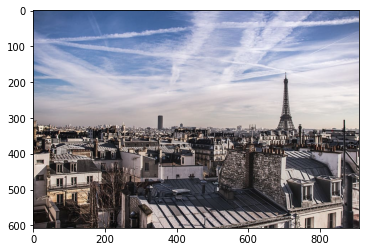

In [73]:
plt.imshow(img2rgb(source))

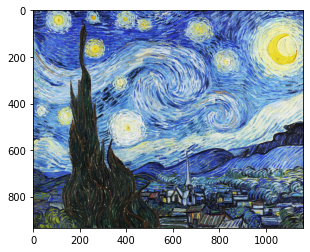

In [74]:
plt.imshow(img2rgb(target))

True

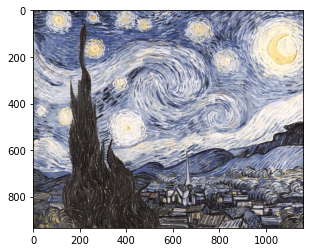

In [75]:
#new - image

plt.imshow(img2rgb(new_bgr))
cv2.imwrite('/content/new_style.jpg', new_bgr)

In [76]:
new_style_reference_img = '/content/new_style.jpg'


In [78]:


iterations = 1000

img_overall_ct = []

for i in range(1, iterations+1):
    loss, grads = compute_loss_and_grads(combination_image, base_image, style_reference_image)
    
    optimizer.apply_gradients([ (grads, combination_image)   ]   )
    if i %100 == 0:
        print("Iteration % d: loss %.2f" % (i, loss))
        img  = deprocess_image(combination_image.numpy())
        img_overall_ct.append(img)
        #fname = "Gen_images"+result_prefix + "_at_iteration_%d.png"%i
        #keras.preprocessing.image.save_img(fname, img)

Iteration  100: loss 5188.12
Iteration  200: loss 5182.11
Iteration  300: loss 5176.42
Iteration  400: loss 5171.05
Iteration  500: loss 5165.96
Iteration  600: loss 5161.13
Iteration  700: loss 5156.55
Iteration  800: loss 5152.20
Iteration  900: loss 5148.07
Iteration  1000: loss 5144.16


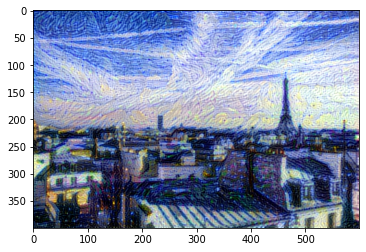

In [80]:
plt.imshow(img_overall_ct[0])

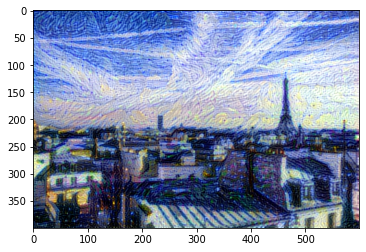

In [82]:
plt.imshow(img_overall_ct[5])

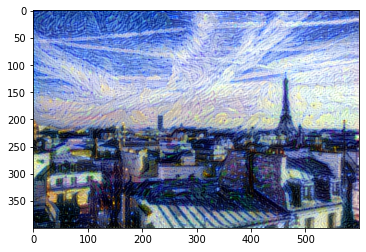

In [83]:
plt.imshow(img_overall_ct[9])

In [ ]:
#even after doing all the sophisticated color transfer - there is no big thing!